# Curve Fitting


The focus of this notebook is on how to perform a linear regression analysis to fit curves to data.
We will also cover how to visualize the results of such curve fitting analyses, i.e. plotting errorbars and residuals.

The core of this code has been adapted from the Experimental Physics [Python Tutorial](https://wiki.uchicago.edu/display/phylabs/Introductory+Lab%3A+Python+Tutorial).

## Setup and Example Data

In [1]:
# Import packages
import numpy as np
from scipy import optimize # this is what we'll use to do our curve fitting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# generate some sample data
n = 101
x = np.linspace(0, 100, n)
xx = x * (1 + (-0.5 + np.random.random(n)) / n)

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

mu = np.mean(x)
sigma = 10
y = gaussian(xx, mu, sigma) * (1 + (-0.5 + np.random.random(n)) / n)
dy = np.sqrt(np.abs(y)) / n

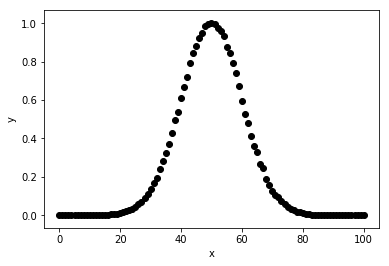

In [3]:
# Visualize the sample data
plt.scatter(x, y, c='k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Linear Regression Analysis

We wil be using the least square optimization from `scipy` to fit a function to our data.

First, we must define our fit function, which will be a simple gaussian, as well as a residual function.

In [4]:
def fitfunc(p,x):
    """
    Fit function
    """
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def residual(p, x, y, err):
    """
    Normalized residuals of the fitfunction to the data
    """
    return (fitfunc(p, x)-y)/err

Now, we give `scipy` our guess to the fit paremeters (`p0`) and print out the results of the fitting procedure.

Feel free to see what happens when you change the initial guesses; how far away from the "true" values can you be?

In [5]:
# fit parameter guess
p0 = [25, 50, 10]

# perform the least square linear regression fit to the data
pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args=(x, y, dy), full_output=1)
if cov is None:
    print('Fit did not converge')
    print('Success code: {}'.format(success))
    print(mesg)
else:
    chisq = sum(info['fvec']*info['fvec'])
    dof = len(x) - len(pf)
    pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
    print('Converged with chi-squared {}'.format(chisq))
    print('Number of degrees of freedom, dof = {}'.format(dof))
    print('Reduced chi-squared {}'.format(chisq/dof))
    print('{:0.2f}% residuals within 1 sigma.'.format((np.abs(residual(pf, x, y, dy)) < 1).sum() / len(x) * 100))
    print('Inital guess values:')
    print('  p0 = {}'.format(p0))
    print('Best fit values:')
    print('  pf = {}'.format(pf))
    print('Uncertainties in the best fit values:')
    print('  pferr = {}'.format(pferr))

Converged with chi-squared 71.02039446836864
Number of degrees of freedom, dof = 98
Reduced chi-squared 0.7246979027384555
74.26% residuals within 1 sigma.
Inital guess values:
  p0 = [25, 50, 10]
Best fit values:
  pf = [25.04203788 49.95590783  9.97158871]
Uncertainties in the best fit values:
  pferr = [0.04954656422949674, 0.01972925934325426, 0.013990258152119716]


## Visualizing the Results

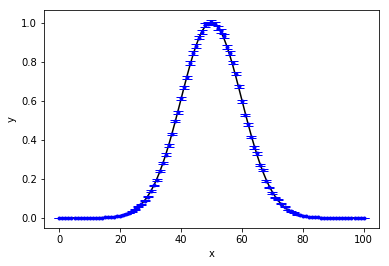

In [6]:
plt.plot(x, fitfunc(pf, x), 'k-')
plt.errorbar(x, y, dy, fmt='b.', capsize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

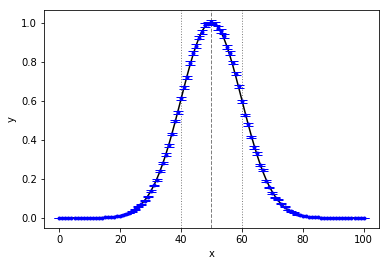

In [7]:
plt.plot(x, fitfunc(pf, x), 'k-', zorder=1)
plt.errorbar(x, y, dy, fmt='b.', capsize=5, zorder=2)
plt.axvline(x=pf[1], ls='--', lw=1, c='gray', zorder=0)
plt.axvline(x=pf[1]-pf[2], ls=':', lw=1, c='gray', zorder=0)
plt.axvline(x=pf[1]+pf[2], ls=':', lw=1, c='gray', zorder=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

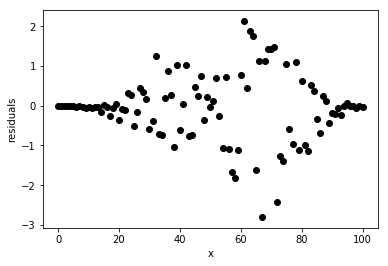

In [8]:
plt.scatter(x, residual(pf, x, y, dy), c='k')
plt.xlabel('x')
plt.ylabel('residuals')
plt.show()

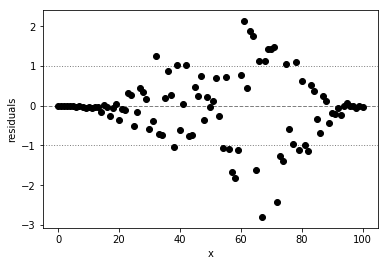

In [9]:
plt.scatter(x, residual(pf, x, y, dy), c='k', zorder=1)
plt.axhline(y=0, ls='--', lw=1, c='gray', zorder=0)
plt.axhline(y=1, ls=':', lw=1, c='gray', zorder=0)
plt.axhline(y=-1, ls=':', lw=1, c='gray', zorder=0)
plt.xlabel('x')
plt.ylabel('residuals')
plt.show()

We'll now use `matplotlib`'s object oriented interface (i.e. `axes`) to draw both plots in one figure.

We also use `text` to give information about the fit to the data in the fit plot.

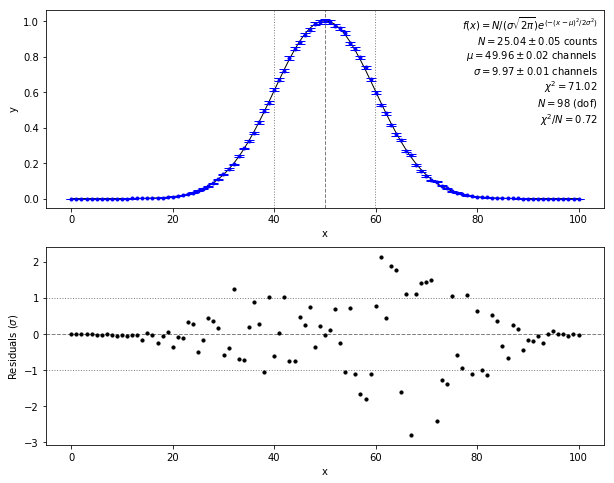

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10,8))

ax = axs[0]
plt.sca(ax)
ax.axvline(x=pf[1], ls='--', lw=1, c='gray', zorder=0)
ax.axvline(x=pf[1]-pf[2], ls=':', lw=1, c='gray', zorder=0)
ax.axvline(x=pf[1]+pf[2], ls=':', lw=1, c='gray', zorder=0)
ax.plot(x, fitfunc(pf, x), 'k-', linewidth=1, zorder=1)
ax.errorbar(x, y, dy, fmt='b.', elinewidth=1, capsize=5, zorder=2)
ax.set_xlabel('x')
ax.set_ylabel('y')

textfit = '$f(x) = N / (\sigma \sqrt{2 \pi}) e^{(-(x - \mu)^2 / 2 \sigma^2)}$ \n' \
          '$N = %.2f \pm %.2f$ counts \n' \
          '$\mu = %.2f \pm %.2f$ channels \n' \
          '$\sigma = %.2f \pm %.2f$ channels \n' \
          '$\chi^2 = %.2f$ \n' \
          '$N = %i$ (dof) \n' \
          '$\chi^2/N = % .2f$' \
           % (pf[0], pferr[0], pf[1], pferr[1], pf[2], pferr[2], chisq, dof, chisq/dof)
ax.text(0.99, 0.975, textfit, transform=ax.transAxes, fontsize=10, horizontalalignment='right', verticalalignment='top')

ax = axs[1]
plt.sca(ax)
ax.axhline(y=0, ls='--', lw=1, c='gray', zorder=0)
ax.axhline(y=1, ls=':', lw=1, c='gray', zorder=0)
ax.axhline(y=-1, ls=':', lw=1, c='gray', zorder=0)
ax.scatter(x, residual(pf, x, y, dy), s=10, c='k', zorder=1)
ax.set_xlabel('x')
ax.set_ylabel('Residuals ($\sigma)$')

plt.show()